ID : HDD의 고유 product number

cr_ID : 조립장비의 고유 번호

assembly_time : 조립장비에서 조립이 시작된 시간

eq_ID : 후공정 장비의 고유 번호

process_time : 후공정이 시작된 시간

ramp : ramp라는 부품의 조립 공차를 후공정에서 측정한 값

servo_defect : 후공정에서 측정된 servo sector의 bad sector 개수

data_defect : 후공정에서 측정된 data sector의 bad sector 개수

status : 신뢰성 테스트의 결과

In [ ]:
import pandas as pd
import numpy as np
import os

os.chdir("/content/drive/MyDrive/ML 대회/HDD")
df = pd.read_csv("./train.csv",parse_dates=["assembly_time","process_time"])
df.head()

,ID,cr_ID,assembly_time,eq_ID,process_time,ramp,servo_defect,data_defect,status
0,HDDSN00000,CRSTR01L,2015-03-09 09:36:00,EGRWT0113,2015-03-09 11:33:55,4561.0,6083.0,1341.0,pass
1,HDDSN00001,CRSTR01Q,2015-03-10 02:13:00,EGRWT0102,2015-03-10 03:16:18,3898.0,1819.0,8037.0,pass
2,HDDSN00002,CRSTR01N,2015-03-06 23:06:00,EGRWT0103,2015-03-07 00:00:12,3016.0,4997.0,1583.0,pass
3,HDDSN00003,CRSTR01A,2015-03-08 05:10:00,EGRWT0107,2015-03-08 06:36:18,1605.0,4415.0,3345.0,pass
4,HDDSN00004,CRSTR01C,2015-03-09 06:44:00,EGRWT0113,2015-03-09 09:13:40,1002.0,2394.0,3296.0,pass


In [ ]:
df.shape

(32000, 9)

In [ ]:
# 범주형 변수
categorical_feature_names = ['ID','cr_ID', 'eq_ID']

for var in categorical_feature_names:
    df[var] = df[var].astype("category")  #카테고리화

In [ ]:
# 조립 시작 시간
df["assem_year"] = df["assembly_time"].dt.year
df["assem_month"] = df["assembly_time"].dt.month
df["assem_day"] = df["assembly_time"].dt.day
df["assem_hour"] = df["assembly_time"].dt.hour
df["assem_min"] = df["assembly_time"].dt.minute
df["assem_sec"] = df["assembly_time"].dt.second

# 후공정 시작 시간
df["pro_year"] = df["process_time"].dt.year
df["pro_month"] = df["process_time"].dt.month
df["pro_day"] = df["process_time"].dt.day
df["pro_hour"] = df["process_time"].dt.hour
df["pro_min"] = df["process_time"].dt.minute
df["pro_sec"] = df["process_time"].dt.second

# 후공정 시작 시간 - 조립 시작 시간
df["pro_assem"] = df["process_time"] - df["assembly_time"]
df["pro_assem"] = df["pro_assem"].dt.total_seconds()  # 초 단위로 변환
###여기까지 base###

df["defect_all"] = df["servo_defect"]+df["data_defect"] #총 bad sector 개수
df["ramp_proassem"] = df["ramp"]/df["pro_assem"]  #ramp ratio
###여기까지 base1###

df["data_proassem"] = df["data_defect"]/df["pro_assem"]
###여기까지 data_proassem###

df["ramp_scale"] =np.log1p(df["ramp"])
df["data_scale"] =np.log1p(df["data_defect"])
df["proassem_scale"] = np.log1p(df["pro_assem"])
###여기까지 rf_log####

df["status1"] = 0
df.loc[df["status"]=="pass","status1"] = 1
tmp1 = df.groupby('assem_day')['status1'].agg(['sum']).rename({'sum':'assem_enc'},axis=1)
df = pd.merge(df,tmp1,on='assem_day',how='left')
###여기까지 lgb_assemenc


In [ ]:
df.head()

,ID,cr_ID,assembly_time,eq_ID,process_time,ramp,servo_defect,data_defect,status,assem_year,assem_month,assem_day,assem_hour,assem_min,assem_sec,pro_year,pro_month,pro_day,pro_hour,pro_min,pro_sec,pro_assem,defect_all,ramp_proassem,data_proassem,ramp_scale,data_scale,proassem_scale,status1,assem_enc
0,HDDSN00000,CRSTR01L,2015-03-09 09:36:00,EGRWT0113,2015-03-09 11:33:55,4561.0,6083.0,1341.0,pass,2015,3,9,9,36,0,2015,3,9,11,33,55,7075.0,7424.0,0.644664,0.189541,8.425516,7.201916,8.864464,1,3536
1,HDDSN00001,CRSTR01Q,2015-03-10 02:13:00,EGRWT0102,2015-03-10 03:16:18,3898.0,1819.0,8037.0,pass,2015,3,10,2,13,0,2015,3,10,3,16,18,3798.0,9856.0,1.026330,2.116114,8.268475,8.991936,8.242493,1,3653
2,HDDSN00002,CRSTR01N,2015-03-06 23:06:00,EGRWT0103,2015-03-07 00:00:12,3016.0,4997.0,1583.0,pass,2015,3,6,23,6,0,2015,3,7,0,0,12,3252.0,6580.0,0.927429,0.486777,8.012018,7.367709,8.087333,1,3564
3,HDDSN00003,CRSTR01A,2015-03-08 05:10:00,EGRWT0107,2015-03-08 06:36:18,1605.0,4415.0,3345.0,pass,2015,3,8,5,10,0,2015,3,8,6,36,18,5178.0,7760.0,0.309965,0.646002,7.381502,8.115521,8.552367,1,3554
4,HDDSN00004,CRSTR01C,2015-03-09 06:44:00,EGRWT0113,2015-03-09 09:13:40,1002.0,2394.0,3296.0,pass,2015,3,9,6,44,0,2015,3,9,9,13,40,8980.0,5690.0,0.111581,0.367038,6.910751,8.100768,9.102867,1,3536


In [ ]:
from sklearn.model_selection import train_test_split
df_tr = df[df.columns.difference(['ID', 'cr_ID', 'assembly_time', 'eq_ID', 'process_time','status','pro_year','pro_month','assem_year','assem_sec','assem_month','status1'])]

X_train, X_test, y_train, y_test = train_test_split(df_tr, df.status, test_size=0.25, stratify=df.status, random_state=123456)

## RandomForest

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred, labels = ['pass','fail'])
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test, pred, pos_label='pass')
    recall = recall_score(y_test,pred, pos_label='pass')
    f1 = f1_score(y_test, pred, pos_label='pass')
    print('Confusion Matrix')
    print(confusion)
    print('Auccuracy : {0:.4f}, Precision : {1:.4f} , Recall : {2:.4f} , F1_Score : {3:.4f}'.format(accuracy , precision, recall, f1))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123456,
                       verbose=0, warm_start=False)

In [ ]:
## Cross Validation  #baseline without importance 0
from sklearn.model_selection import cross_val_score, KFold
# K-fold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(rf, df_tr, df.status, cv=kfold)
print("K-fold Score:", scores_fold.mean())

y_pred = rf.predict(X_test)
get_clf_eval(y_test,y_pred)

K-fold Score: 0.908
Confusion Matrix
[[4932  588]
 [ 143 2337]]
Auccuracy : 0.9086, Precision : 0.9718 , Recall : 0.8935 , F1_Score : 0.9310


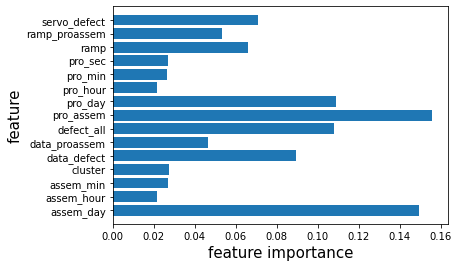

In [ ]:
import matplotlib.pyplot as plt
index = np.arange(df_tr.shape[1])
plt.barh(index, rf.feature_importances_, align='center')
plt.yticks(index, X_train)
plt.ylim(-1, df_tr.shape[1])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()   #### 불필요한 feature 판단  # 'pro_year','pro_month','assem_year','assem_sec','assem_month'

## LGB

In [ ]:
#####LGB####
from lightgbm import LGBMClassifier
## best parameters found.
lgb = LGBMClassifier(objective='binary',learning_rate=0.05)
lgb.fit(X_train,y_train)
## Cross Validation  #baseline without importance 0
from sklearn.model_selection import cross_val_score, KFold
# K-fold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(lgb, df_tr, df.status, cv=kfold)
print("K-fold Score:", scores_fold.mean())

y_pred = lgb.predict(X_test)
get_clf_eval(y_test,y_pred)

K-fold Score: 0.9091562499999999
Confusion Matrix
[[4914  606]
 [ 124 2356]]
Auccuracy : 0.9087, Precision : 0.9754 , Recall : 0.8902 , F1_Score : 0.9309


# For Submission

In [ ]:
###downsampling####
import math
count_1, count_0 = df.status.value_counts()

df_1 = df[df.status == "pass"]
df_0 = df[df.status == "fail"]
df_1_over = df_1.sample(math.floor(count_0), replace= True, random_state = 123)  #sampling ratio
df_over = pd.concat([df_1_over, df_0], axis=0)
df_over.status.value_counts()

fail    9919
pass    9919
Name: status, dtype: int64

In [ ]:
len(df_over.columns.values)

30

In [ ]:
# import math
# count_1, count_0 = df.status.value_counts()

# df_1 = df[df.status == "pass"]
# df_0 = df[df.status == "fail"]
# df_0_over = df_0.sample(math.floor(count_1), replace= True, random_state = 123)  #sampling ratio
# df_over = pd.concat([df_1, df_0_over], axis=0)

df_tr = df_over[df_over.columns.difference(['ID', 'cr_ID', 'assembly_time', 'eq_ID', 'process_time','status','pro_year','pro_month','assem_year','assem_sec','assem_month','status1'])]

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(df_tr, df_over.status)
# lgb = LGBMClassifier(objective='binary', boosting='gbdt',learning_rate = 0.05,max_depth=20,num_leaves=2^20,min_data_in_leaf=1000)
# lgb.fit(df_tr,df_over.status)

import pickle
filename = './model/rf_assemenc.sav'  #모델명 변경
pickle.dump(rf, open(filename, 'wb'))  #모델명 체크

In [ ]:
import pandas as pd
import numpy as np
import os

os.chdir("/content/drive/MyDrive/ML 대회/HDD")
test = pd.read_csv("./test.csv",parse_dates=["assembly_time","process_time"])
df = pd.concat([df,test])
categorical_feature_names = ['ID','cr_ID', 'eq_ID' ]
for var in categorical_feature_names:
    df[var] = df[var].astype("category")  #카테고리화

# 조립 시작 시간
df["assem_year"] = df["assembly_time"].dt.year
df["assem_month"] = df["assembly_time"].dt.month
df["assem_day"] = df["assembly_time"].dt.day
df["assem_hour"] = df["assembly_time"].dt.hour
df["assem_min"] = df["assembly_time"].dt.minute
df["assem_sec"] = df["assembly_time"].dt.second

# 후공정 시작 시간
df["pro_year"] = df["process_time"].dt.year
df["pro_month"] = df["process_time"].dt.month
df["pro_day"] = df["process_time"].dt.day
df["pro_hour"] = df["process_time"].dt.hour
df["pro_min"] = df["process_time"].dt.minute
df["pro_sec"] = df["process_time"].dt.second

# 후공정 시작 시간 - 조립 시작 시간
df["pro_assem"] = df["process_time"] - df["assembly_time"]
df["pro_assem"] = df["pro_assem"].dt.total_seconds()  # 초 단위로 변환

df["defect_all"] = df["servo_defect"]+df["data_defect"] #총 bad sector 개수
df["ramp_proassem"] = df["ramp"]/df["pro_assem"]  #ramp ratio

df["data_proassem"] = df["data_defect"]/df["pro_assem"]

df["ramp_scale"] =np.log1p(df["ramp"])
df["data_scale"] =np.log1p(df["data_defect"])
df["proassem_scale"] = np.log1p(df["pro_assem"])

mapping = dict(df_tr[['assem_day', 'assem_enc']].values)
df["assem_enc"] = df.assem_day.map(mapping).astype(int)

In [ ]:
df.head()

,ID,cr_ID,assembly_time,eq_ID,process_time,ramp,servo_defect,data_defect,status,assem_year,assem_month,assem_day,assem_hour,assem_min,assem_sec,pro_year,pro_month,pro_day,pro_hour,pro_min,pro_sec,pro_assem,defect_all,ramp_proassem,data_proassem,ramp_scale,data_scale,proassem_scale,status1,assem_enc
0,HDDSN00000,CRSTR01L,2015-03-09 09:36:00,EGRWT0113,2015-03-09 11:33:55,4561.0,6083.0,1341.0,pass,2015,3,9,9,36,0,2015,3,9,11,33,55,7075.0,7424.0,0.644664,0.189541,8.425516,7.201916,8.864464,1.0,3536
1,HDDSN00001,CRSTR01Q,2015-03-10 02:13:00,EGRWT0102,2015-03-10 03:16:18,3898.0,1819.0,8037.0,pass,2015,3,10,2,13,0,2015,3,10,3,16,18,3798.0,9856.0,1.026330,2.116114,8.268475,8.991936,8.242493,1.0,3653
2,HDDSN00002,CRSTR01N,2015-03-06 23:06:00,EGRWT0103,2015-03-07 00:00:12,3016.0,4997.0,1583.0,pass,2015,3,6,23,6,0,2015,3,7,0,0,12,3252.0,6580.0,0.927429,0.486777,8.012018,7.367709,8.087333,1.0,3564
3,HDDSN00003,CRSTR01A,2015-03-08 05:10:00,EGRWT0107,2015-03-08 06:36:18,1605.0,4415.0,3345.0,pass,2015,3,8,5,10,0,2015,3,8,6,36,18,5178.0,7760.0,0.309965,0.646002,7.381502,8.115521,8.552367,1.0,3554
4,HDDSN00004,CRSTR01C,2015-03-09 06:44:00,EGRWT0113,2015-03-09 09:13:40,1002.0,2394.0,3296.0,pass,2015,3,9,6,44,0,2015,3,9,9,13,40,8980.0,5690.0,0.111581,0.367038,6.910751,8.100768,9.102867,1.0,3536


In [ ]:
df = df[df["status"].isnull()]
df_tr = df[df.columns.difference(['ID', 'cr_ID', 'assembly_time', 'eq_ID', 'process_time','status','pro_year','pro_month','assem_year','assem_sec','assem_month','status1'])]

model = pickle.load(open('./model/rf_assemenc.sav', 'rb'))  #모델명 변경
prediction = model.predict(df_tr)
submission = pd.DataFrame(prediction, columns=["status"])
submission.head()

,status
0,pass
1,pass
2,pass
3,pass
4,fail


In [ ]:
submission.value_counts()   ##lgb_dataproassem_down  ###91.375

status
pass      5071
fail      2929
dtype: int64

In [ ]:
submission.to_csv("./Submission/lgb_assemenc.csv", index=False)

In [ ]:
## drop!!!
# df["servo_proassem"] = df["servo_defect"]/df["pro_assem"]  #servo defect ratio
# df["data_proassem"] = df["data_defect"]/df["pro_assem"]  #data defect ratio
# from sklearn.cluster import KMeans
# df["cluster"] = KMeans(n_clusters = 10).fit_predict(df[['pro_assem','assem_day','pro_day','defect_all']])  ###컬럼 중요도 높은거로 바꿔보자!!
# df["cluster"] = df["cluster"].astype("category")

# df["ramp_servo"] = df["ramp"]+df["servo_defect"]  ##살짝 애매 91.3 #kfold는 오름
# df["ramp_data"] = df["ramp"]+df["data_defect"]